In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [2]:
geo = "GSE94536"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Li2017", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [3]:
table = pd.concat((val.table.iloc[:,1:] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [4]:
table

,0,1,2,3,4,5,6,7,8,9,...,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,3.78867,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,2.84215,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,9.53514,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,4.16109,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,5.93378,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,0.10000,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,1.55445,0.10000,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,2.10564,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,0.10000,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,283.80890,0.1,0.1,0.1,63.38276,10.58558,124.8117,0.1,15.65303,...,0.1,0.1,0.1,344.32600,0.1,6.70158,0.1,0.1,0.1,2.75548
VALUE,0.10000,249.27970,0.1,0.1,0.1,68.02007,9.89041,107.1587,0.1,2.45958,...,0.1,0.1,0.1,394.66400,0.1,4.75734,0.1,0.1,0.1,0.10000
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.10000,3.77247,0.1000,0.1,0.10000,...,0.1,0.1,0.1,3.71492,0.1,0.10000,0.1,0.1,0.1,0.10000


### Seperate case and controls

In [5]:
list(data.gsms.values())[1].metadata

{'title': ['Patient 2 257015610720_S01_ALK-neg-2'],
 'geo_accession': ['GSM2477855'],
 'status': ['Public on Feb 07 2017'],
 'submission_date': ['Feb 06 2017'],
 'last_update_date': ['Feb 07 2017'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['primary lung cancer'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['plasma: primary lung cancer',
  'age: 43 years',
  'gender: Female',
  'smoking history: No',
  'histology: Adenocarcinoma',
  'clinical stage: IV',
  'alk mutational status: ALK negative'],
 'treatment_protocol_ch1': ['All the participants enrolled had 7ml peripheral venous blood samples collected in the fasting state at morning. Plasma was separated within 30 minutes since the sample collection with the centrifugation at 4,500Ã—g for 10 minutes at 4 â„ƒ and then stored immediately at -80â„ƒ for further measurements.'],
 'growth_protocol_ch1': ['Not applicable'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': 

In [6]:
set([k.metadata["characteristics_ch1"][0] for k in list(data.gsms.values())])

{'plasma: healthy donor', 'plasma: primary lung cancer'}

In [7]:
sick = np.array(["cancer" in k.metadata["characteristics_ch1"][0] for k in list(data.gsms.values())])
controls = 1 - sick

In [8]:
sum(controls)

3

### Drop NAN

In [9]:
mask = table.std() != 0
table = table.loc[:, mask]
mirnas = mirnas[mask]

In [10]:
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_26288/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [11]:
X = table

In [12]:
X

,0,1,5,6,7,9,12,14,16,19,...,2516,2519,2523,2526,2529,2531,2532,2542,2544,2548
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,2.81054,0.10000,...,119.19110,0.10000,5.03178,0.10000,1.84522,9.35345,0.10000,3.78867,0.10000,0.10000
VALUE,0.10000,2.84215,0.10000,0.10000,0.1000,0.10000,3.48693,2.85913,8.86201,0.10000,...,74.26930,0.10000,8.81913,0.10000,3.32140,4.58324,0.10000,9.53514,0.10000,0.10000
VALUE,0.10000,4.16109,0.10000,0.10000,0.1000,0.10000,4.04358,2.80796,7.24243,0.10000,...,38.17760,0.10000,3.63730,0.10000,0.10000,7.84305,0.10000,5.93378,0.10000,0.10000
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,20.03903,0.10000,2.25616,0.10000,0.10000,3.04235,1.56216,0.10000,0.10000,0.10000
VALUE,1.55445,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,24.17352,1.25686,0.10000,3.59980,8.85093,11.77476,0.10000,2.10564,0.10000,0.10000
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,6.70371,0.10000,0.10000,0.10000,0.10000,5.57755,0.10000,0.10000,0.10000,0.10000
VALUE,0.10000,283.80890,63.38276,10.58558,124.8117,15.65303,188.35280,114.28900,222.61160,3.33573,...,368.86600,0.10000,82.53000,6.89714,15.07545,7.70800,0.10000,344.32600,6.70158,2.75548
VALUE,0.10000,249.27970,68.02007,9.89041,107.1587,2.45958,144.14910,100.13010,235.91000,2.64779,...,470.08000,0.10000,103.08610,8.66296,23.73170,11.11048,0.10000,394.66400,4.75734,0.10000
VALUE,0.10000,0.10000,0.10000,3.77247,0.1000,0.10000,1.66250,0.10000,0.10000,0.10000,...,85.64210,0.10000,2.14897,4.22067,6.49181,14.77457,0.10000,3.71492,0.10000,0.10000


In [13]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [14]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [15]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [16]:
mirnas.iloc[lowest], pvalues

(1220    A_25_P00016339
 1091    A_25_P00017131
 1440    A_25_P00010431
 126     A_25_P00015195
 1863    A_25_P00017983
 Name: ID_REF, dtype: object,
 array([2.20065395e-08, 1.63215772e-07, 1.36146586e-06, 2.99123328e-06,
        3.26820982e-06]))

### F-test

In [17]:
t3 = table

In [18]:
f, p = f_classif(t3, sick)

In [19]:
np.mean(p)

0.15056040848702015

### ANOVA

In [20]:
t3

,0,1,5,6,7,9,12,14,16,19,...,2516,2519,2523,2526,2529,2531,2532,2542,2544,2548
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,2.81054,0.10000,...,119.19110,0.10000,5.03178,0.10000,1.84522,9.35345,0.10000,3.78867,0.10000,0.10000
VALUE,0.10000,2.84215,0.10000,0.10000,0.1000,0.10000,3.48693,2.85913,8.86201,0.10000,...,74.26930,0.10000,8.81913,0.10000,3.32140,4.58324,0.10000,9.53514,0.10000,0.10000
VALUE,0.10000,4.16109,0.10000,0.10000,0.1000,0.10000,4.04358,2.80796,7.24243,0.10000,...,38.17760,0.10000,3.63730,0.10000,0.10000,7.84305,0.10000,5.93378,0.10000,0.10000
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,20.03903,0.10000,2.25616,0.10000,0.10000,3.04235,1.56216,0.10000,0.10000,0.10000
VALUE,1.55445,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,24.17352,1.25686,0.10000,3.59980,8.85093,11.77476,0.10000,2.10564,0.10000,0.10000
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,6.70371,0.10000,0.10000,0.10000,0.10000,5.57755,0.10000,0.10000,0.10000,0.10000
VALUE,0.10000,283.80890,63.38276,10.58558,124.8117,15.65303,188.35280,114.28900,222.61160,3.33573,...,368.86600,0.10000,82.53000,6.89714,15.07545,7.70800,0.10000,344.32600,6.70158,2.75548
VALUE,0.10000,249.27970,68.02007,9.89041,107.1587,2.45958,144.14910,100.13010,235.91000,2.64779,...,470.08000,0.10000,103.08610,8.66296,23.73170,11.11048,0.10000,394.66400,4.75734,0.10000
VALUE,0.10000,0.10000,0.10000,3.77247,0.1000,0.10000,1.66250,0.10000,0.10000,0.10000,...,85.64210,0.10000,2.14897,4.22067,6.49181,14.77457,0.10000,3.71492,0.10000,0.10000


In [21]:
X = np.array(sick).reshape(-1, 1)

In [22]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [23]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.4753435358031404

### Mean-variance-plot

In [24]:
np.mean(table)

0        0.261606
1       60.065760
5       14.678092
6        2.760940
7       25.852267
          ...    
2531     8.418606
2532     0.262462
2542    84.918683
2544     1.350991
2548     0.395053
Length: 454, dtype: float64

In [25]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [26]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

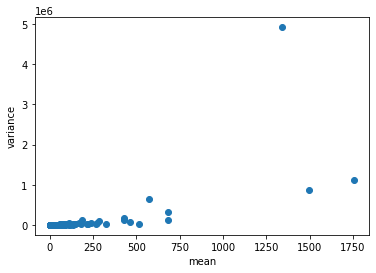

In [27]:
mean_variance_plot(table)

### Log transformation

In [28]:
log_table = table #np.log2(table)

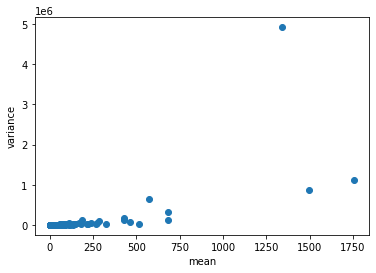

In [29]:
mean_variance_plot(log_table)

### Loess regression

In [30]:
lowess = LowessRegression(sigma=1, span=0.1)

In [31]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [32]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

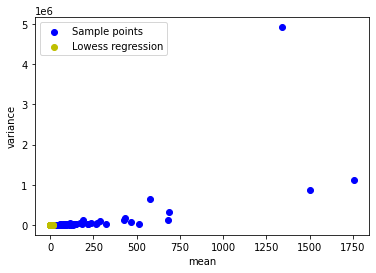

In [33]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

In [34]:
norm_log_table = log_table #- np.mean(log_table)

In [35]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

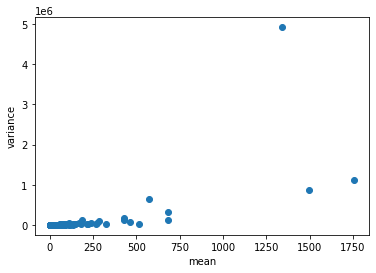

In [36]:
mean_variance_plot(norm_log_table)

### PCA

In [37]:
pca = decomposition.PCA(n_components=2)

In [38]:
pca.fit(norm_log_table)

PCA(n_components=2)

In [39]:
pca.explained_variance_ratio_

array([0.8002302 , 0.16125823])

In [40]:
components = pca.transform(norm_log_table)

In [41]:
components.shape

(9, 2)

In [42]:
sum(controls)

3

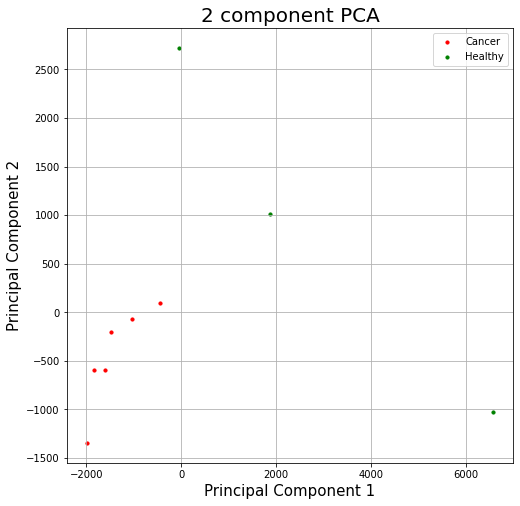

In [43]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [44]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

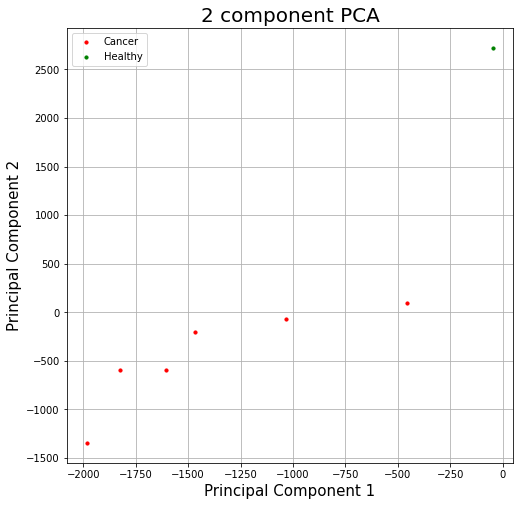

In [45]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [46]:
sex = np.array(["Female" in k.metadata["characteristics_ch1"][2] for k in list(data.gsms.values()) if "post" not in k.metadata["characteristics_ch1"][0]])
age = np.array([float(k.metadata["characteristics_ch1"][1].split(" ")[1].replace("NA", "NaN")) for k in list(data.gsms.values()) if "post" not in k.metadata["characteristics_ch1"][0]])

In [47]:
covars = pd.DataFrame(np.array([sex, age]).transpose(), columns=["sex", "age"])

In [48]:
covars = covars.fillna(covars.mean())

In [49]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [50]:
adj_norm_log_table = norm_log_table #- linreg.predict(covars)

# PCA

In [51]:
pca = decomposition.PCA(n_components=2)

In [52]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [53]:
components = pca.transform(adj_norm_log_table)

In [54]:
components

array([[-1469.78530888,  -199.49522348],
       [ -455.5751798 ,    92.46965098],
       [-1607.92750419,  -590.34885389],
       [-1826.47763559,  -594.49003031],
       [-1035.71751874,   -64.10904247],
       [-1981.87791311, -1345.19792665],
       [ 1859.66871107,  1009.24336877],
       [ 6564.57593218, -1030.95250644],
       [  -46.88358294,  2722.88056349]])

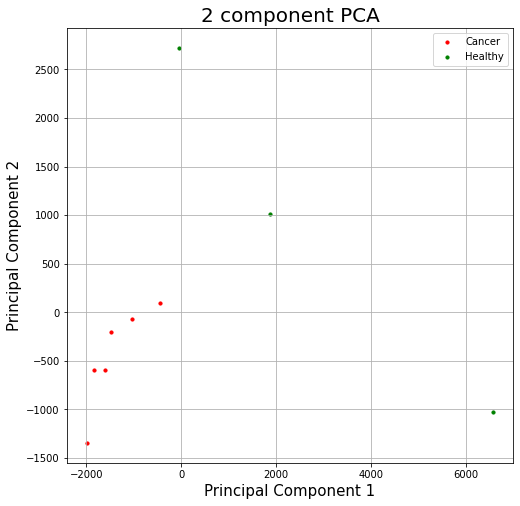

In [55]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [56]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [57]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


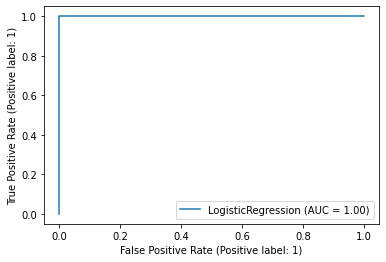

In [58]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [59]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[19:01:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


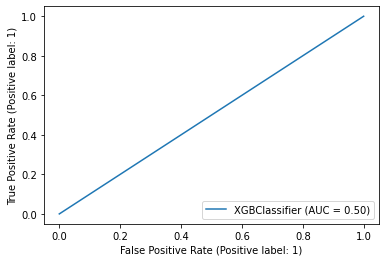

In [60]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [61]:
lookup_table = data.gpls["GPL21576"].table

In [62]:
lookup_table = lookup_table.set_index("ID")
lookup_table.head()

,miRNA_ID,SPOT_ID,GENE_SYMBOL,GENE_NAME,ACCESSION_STRING,CHROMOSOMAL_LOCATION,SPOT_ID.1
ID,,,,,,,
(-)3xSLv1,NaN,--NegativeControl,NaN,NaN,NaN,NaN,NaN
A_25_P00010019,hsa-miR-329-3p,NaN,hsa-miR-329-3p,hsa-miR-329-3p,mir|hsa-miR-329-3p|mir|MIMAT0001629|mir|hsa-mi...,"chr14:101493173-101493192,chr14:101493490-1014...",NaN
A_25_P00010020,hsa-miR-329-3p,NaN,hsa-miR-329-3p,hsa-miR-329-3p,mir|hsa-miR-329-3p|mir|MIMAT0001629|mir|hsa-mi...,"chr14:101493174-101493192,chr14:101493491-1014...",NaN
A_25_P00010021,hsa-miR-655-3p,NaN,hsa-miR-655-3p,hsa-miR-655-3p,mir|hsa-miR-655-3p|mir|MIMAT0003331|mir|hsa-mi...,chr14:101515949-101515968,NaN
A_25_P00010023,hsa-miR-369-3p,NaN,hsa-miR-369-3p,hsa-miR-369-3p,mir|hsa-miR-369-3p|mir|MIMAT0000721,unmapped,NaN


In [63]:
access_ids = lookup_table.loc[mirnas]["ACCESSION_STRING"]

In [64]:
access_ids = [a.split("|")[-1] for a in access_ids]

In [65]:
access_ids[:10]

['MIMAT0004481',
 'MIMAT0000062',
 'MIMAT0000064',
 'MIMAT0004484',
 'MIMAT0000065',
 'MIMAT0000066',
 'MIMAT0000067',
 'MIMAT0000414',
 'MIMAT0000415',
 'MIMAT0000099']

In [66]:
from Scripts import converters

In [67]:
sequences = converters.mirbase_to_seq(access_ids)

In [68]:
sequences[:10]

['CUAUACAAUCUACUGUCUUUC',
 'UGAGGUAGUAGGUUGUAUAGUU',
 'UGAGGUAGUAGGUUGUAUGGUU',
 'CUAUACGACCUGCUGCCUUUCU',
 'AGAGGUAGUAGGUUGCAUAGUU',
 'UGAGGUAGGAGGUUGUAUAGUU',
 'UGAGGUAGUAGAUUGUAUAGUU',
 'UGAGGUAGUAGUUUGUACAGUU',
 'UGAGGUAGUAGUUUGUGCUGUU',
 'UACAGUACUGUGAUAACUGAA']

In [69]:
adj_norm_log_table.columns = sequences
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

,CUAUACAAUCUACUGUCUUUC,UGAGGUAGUAGGUUGUAUAGUU,UGAGGUAGUAGGUUGUAUGGUU,CUAUACGACCUGCUGCCUUUCU,AGAGGUAGUAGGUUGCAUAGUU,UGAGGUAGGAGGUUGUAUAGUU,UGAGGUAGUAGAUUGUAUAGUU,UGAGGUAGUAGUUUGUACAGUU,UGAGGUAGUAGUUUGUGCUGUU,UACAGUACUGUGAUAACUGAA,...,ACUGCUGAGCUAGCACUUCCCG,ACAGUAGAGGGAGGAAUCGCAG,UGCCCUUAAAGGUGAACCCAGU,AUAAAGCUAGAUAACCGAAAGU,CACCCGGCUGUGUGCACAUGUGC,CACAUGGCCGAAACAGAGAAGU,UGAGGUAGUAAGUUGUAUUGUU,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.1,0.10000,0.10000,2.81054,0.1,...,0.10000,5.03178,0.1000,1.84522,9.35345,0.10000,3.78867,0.1,0.1,True
VALUE,0.10000,2.84215,0.1,0.1,0.1,0.1,3.48693,2.85913,8.86201,0.1,...,0.10000,8.81913,0.1000,3.32140,4.58324,0.10000,9.53514,0.1,0.1,True
VALUE,0.10000,4.16109,0.1,0.1,0.1,0.1,4.04358,2.80796,7.24243,0.1,...,0.10000,3.63730,0.1000,0.10000,7.84305,0.10000,5.93378,0.1,0.1,True
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.1,0.10000,0.10000,0.10000,0.1,...,0.10000,2.25616,0.1000,0.10000,3.04235,1.56216,0.10000,0.1,0.1,True
VALUE,1.55445,0.10000,0.1,0.1,0.1,0.1,0.10000,0.10000,0.10000,0.1,...,1.25686,0.10000,3.5998,8.85093,11.77476,0.10000,2.10564,0.1,0.1,True


In [70]:
adj_norm_log_table.to_csv("../TransformedData/Li2017_raw.csv", index=False)